In [653]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
import seaborn as sns
sns.set()

def LHS(x,x0):
    return ((x**2/x0)**2)


def RHS(x, x1, x2):
    return 2/x2 + x1/((x-x1)*x2)


def bisection(x0,x1,x2, err):

    x = [0,x1/4, x1/2]
    check = min(list(abs(RHS(x[i],x1,x2)-LHS(x[i], x0)) for i in range(2)))
    index = np.argmin(list(abs(RHS(x[i],x1,x2)-LHS(x[i], x0)) for i in range(2)))
    
    while check >= err:
        test = np.sign(list(RHS(x[i],x1,x2)-LHS(x[i], x0) for i in range(3)))
        if test[0]==test[1]:
            x = [x[1],(x[1]+x[2])/2,x[2]]
        elif test[1]==test[2]:
            x = [x[0],(x[0]+x[1])/2,x[1]]
        check = min(list(abs(RHS(x[i],x1,x2)-LHS(x[i], x0)) for i in range(2)))
        index = np.argmin(list(abs(RHS(x[i],x1,x2)-LHS(x[i], x0)) for i in range(2)))
    return x[index]

def get_news(h,h0,cons, cons_,phi,r,xi):
    return (-h +h0*np.tanh((cons-cons_)/cons_) + xi) -phi*r + h
def get_kd(kd_old, h, h_old, beta1, beta2):
    return kd_old + beta1*(h-h_old) + beta2*h_old



def get_working_hours(c,u,G,I,g):
    return u/(g*c) + G*(u*I)/(2*c*g*(c-G*I))
def get_feedback(x,x0,xmin,xmax,a): 
    return 1-0.5*(np.tanh(a*(x-x0))*(xmax-xmin)+xmax+xmin)
def get_production(y_old, n_old, k_old , rho, z, tau_y):
    return z*(k_old**rho)*(n_old**(1-rho))
def get_wage(u_old, n_old, k_old , rho, z, tau_u):
    return (1-rho)*z*(k_old**rho)*(n_old**(-rho))




T = 1000
    
    
### SET PARAMETERS ###

inflation = .01
interests = 0.01
gamma = 1
phi = 1.2

gamma_r = gamma*(1+interests)

depr = .2

beta1 = 0.4
beta2 = 0.4
news_old = 1
news_ = []

### SET FEEDBACK PARAMETERS ###

theta  = 5
k0 = 6
xmax = 1
xmin = 0.

### SET NOISY TERMS ###

etaZ = .2
sigmaZ = .8
zbar = 1

### INITIALISE VECTORS ###

consumption = []
investments = []
labour = []
bonds = []
feed = []
wage = []
capital = []
technology = []

### SET VARIABLES AT TIME T0 ###

u_ = 1
lab_ = 1
b_ = 1

cons_ = 1
xi_ = 0
news = 0
news_ = 0
ks_= 1
kd_ = .1
k_ = 5
y_ = 1
u_ = 1

for t in range(T):
    
    xi = etaZ*xi_ + np.sqrt(1-etaZ**2)*np.random.normal(0,sigmaZ)
    z  = zbar*np.exp(xi_)
    
    
    income = u_*lab_ + b_/(1+inflation) 
    feedback = get_feedback(news_,k0,xmin,xmax,theta)
    ks = (1-feedback)*income

    news = get_news(1,1,k, k_,.1,interests,0)#(1-b)*((k-k_)/k_ + np.random.uniform(-.1,.1)) + b*news_
    #kd = get_kd(kd_, news, news_, beta1, beta2)

   
    k = ks + (1-depr)*k_ 
    news = get_news(1,1,k, k_,.1,interests,xi)
    x0 = z*np.sqrt(2*k)
    x1 = feedback*income
    x2 = gamma_r
    
    cons = bisection(x0,x1,x2, 1e-2)
    
    #print([z,x0, x1,x2])
    
    prod = cons
    

    lab = max((cons**2)/(4*k*(z**2)),10)
    u = .5*cons/lab
    
    b = (feedback*income - cons)*(1+interests)
    
    technology.append(z)
    capital.append(k)
    consumption.append(cons)
    labour.append(lab)
    bonds.append(b)
    investments.append(max(min(kd,ks),0))
    feed.append(feedback)
    wage.append(u)
    
    cons_ =np.copy(cons)
    ks_ =np.copy(ks)
    kd_ =np.copy(k)
    b_ += np.copy(b)
    u_ = np.copy(u)
    lab_ = np.copy(lab)
    xi_ = np.copy(xi)
    news_ = np.copy(news)
    prod_ = np.copy(prod)
    k_ = np.copy(k)

/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


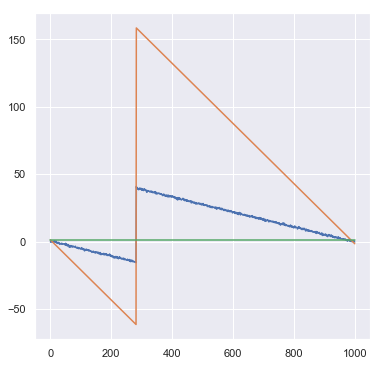

In [654]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(np.log(consumption))
ax.plot(np.log(capital))
ax.plot(feed)
#ax[0].plot(np.log(labour))
#ax[0].plot(np.log(bonds))
#ax.plot(np.log(consumption))

#ax[0].set_xlim([750,1250])


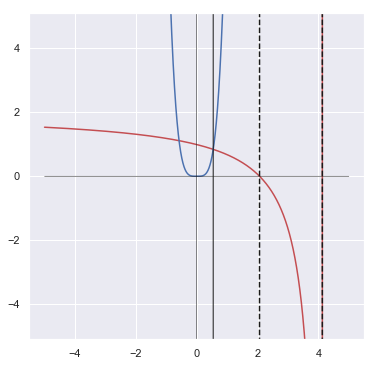

In [538]:
g = 4.12691520115423
gr = 1.01
x0 = 0.3195333487091828
nx = 10000
x = np.linspace(-5,5,nx)

fig, ax = plt.subplots(figsize = (6,6))

ax.plot(x, RHS(x, g, gr), color = 'r')
ax.plot(x, LHS(x,x0), color = 'b')


cons = bisection(x0,g,gr, 1e-4)

ax.plot(x, x*0,  color = 'k', linewidth = .5)
ax.plot(g*np.ones(nx), np.linspace(-25,25,nx),  '--', color = 'k')
ax.plot(g/2*np.ones(nx), np.linspace(-25,25,nx),  '--', color = 'k')
ax.plot(cons*np.ones(nx), np.linspace(-25,25,nx),linewidth = 1, color = 'k')
ax.plot(0*np.ones(nx), np.linspace(-25,25,nx), color = 'k', linewidth = .5)
ax.set_ylim([-10,10])
ax.set_ylim([-5.1,5.1])
plt.savefig('/Users/fedemoro/Desktop/test.pdf', format='pdf',bbox_inches = 'tight',transparent=True)

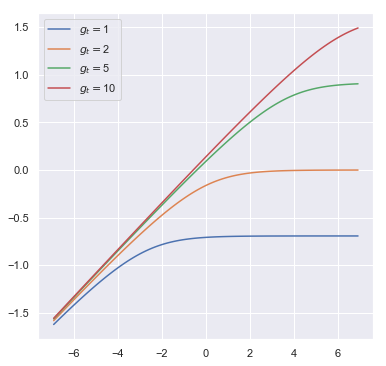

In [579]:
z = 1
#g = 5
gr = 1

fig, ax = plt.subplots(1,1,figsize = (6,6))

capital = np.logspace(-3,3,100)

for g in [1,2,5,10]:
    cons = []
    for k in capital:
        cons.append(bisection(z*np.sqrt(2*k),g,gr, 1e-4))
    ax.plot(np.log(capital), np.log(cons), label= r'$g_t = $' + str(g))
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend()
#plt.plot(capital, g-np.asarray(cons))
plt.savefig('/Users/fedemoro/Desktop/sols.eps', format='eps',bbox_inches = 'tight')#,transparent=True)